# Tackling the Generative Learning Trilemma with Denoising Diffusion GANs

This notebook explores the generative learning trilemma using Denoising Diffusion GANs. It investigates the diffusion process and implements the paper's Denoising Diffusion GANs model.

## Table of Contents
1. [Investigating the Diffusion Process](#investigating-the-diffusion-process)
   - [Forward Diffusion](#forward-diffusion)
   - [Reverse Diffusion](#reverse-diffusion)
2. [Running the Paper's Denoising Diffusion GANs](#running-the-papers-denoising-diffusion-gans)
    - [Discriminator Update](#discriminator-update)
    - [Generator Update](#generator-update)
    - [Sampling with Denoising Diffusion GAN](#sampling-with-denoising-diffusion-gan)
---



In [ ]:
!pip install numpy matplotlib scipy tqdm

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import gaussian_kde
import os
from tqdm import tqdm
np.random.seed(42)

# Parameters for different Gaussian distributions
num_samples = 1000
mean_1, std_1 = 0, 1
mean_2, std_2 = 5, 2
mean_3, std_3 = -3, 0.5

# Generate random samples
gaussian_data_1 = np.random.normal(mean_1, std_1, num_samples)
gaussian_data_2 = np.random.normal(mean_2, std_2, num_samples)
gaussian_data_3 = np.random.normal(mean_3, std_3, num_samples)
x_0 = np.concatenate([gaussian_data_1, gaussian_data_2, gaussian_data_3])

# Beta scheduler functions
def linear_beta_schedule(T, beta_min, beta_max):
    return np.linspace(beta_min, beta_max, T)

def constant_beta_schedule(T, beta_value):
    return np.full(T, beta_value)

def exponential_beta_schedule(T, beta_min, beta_max):
    return np.exp(np.linspace(np.log(beta_min), np.log(beta_max), T))

# KL divergence calculation function
def calculate_kl_divergence(true_dist, approx_dist):
    kde_true = gaussian_kde(true_dist, bw_method='silverman')
    kde_approx = gaussian_kde(approx_dist, bw_method='silverman')
    x_grid = np.linspace(min(true_dist.min(), approx_dist.min()), max(true_dist.max(), approx_dist.max()), 1000)
    p_true = kde_true(x_grid)
    p_approx = kde_approx(x_grid)
    p_true /= np.sum(p_true)
    p_approx /= np.sum(p_approx)
    return np.sum(p_true * np.log(p_true / p_approx))

## Investigating the Diffusion Process
### Forward Diffusion
The forward process introduces a Markovian structure for the latent variable $ x_t $, defined as:


\begin{align*}
x_t = \sqrt{1-\beta_t}x_{t-1} + \sqrt{\beta_t} z_t, \quad z_t \sim \mathcal{N}(0, I).
\end{align*}


### Mean of $ q(x_t|x_0) $

The expected value of $ x_t $ given $ x_0 $ is computed iteratively:


\begin{align*}
    \mathbb{E}(x_t | x_0) &= \sqrt{1-\beta_t} \cdot \mathbb{E}(x_{t-1} | x_0) \\
    &= \sqrt{1-\beta_t} \cdot \sqrt{1-\beta_{t-1}} \cdot \mathbb{E}(x_{t-2} | x_0) \\
    &\quad \vdots \\
    &= \left( \prod_{i=1}^t \sqrt{1-\beta_i} \right)x_0.
\end{align*}


### Covariance of $ q(x_t|x_0) $

The covariance of $ x_t $ given $ x_0 $ is derived from the iterative relationship:


\begin{align*}
    \text{Cov}(x_t | x_0) &= \mathbb{E}[\text{Cov}(x_t | x_{t-1}, x_0) | x_0] + \text{Cov}(\mathbb{E}[x_t | x_{t-1}, x_0] | x_0) \\
    &= \beta_t I + (1-\beta_t)\text{Cov}(x_{t-1} | x_0).
\end{align*}


Expanding recursively:


\begin{align*}
    \text{Cov}(x_t | x_0) &= \beta_t I + (1-\beta_t)\left[\beta_{t-1} I + (1-\beta_{t-1})\text{Cov}(x_{t-2} | x_0)\right], \\
    &\quad \vdots \\
    &= \left( 1 - \prod_{i=1}^t (1-\beta_i) \right)I.
\end{align*}


### Distribution of $ q(x_t|x_0) $

Combining the mean and covariance results, the forward dynamics define a Gaussian distribution:


$$ q(x_t | x_0) = \mathcal{N}\left(x_t; \left( \prod_{i=1}^t \sqrt{1-\beta_i} \right)x_0, \left( 1 - \prod_{i=1}^t (1-\beta_i) \right)I \right). $$


### Asymptotic Behavior

As $ t \to T $ and $ \beta_t \to 0 $, the distribution $ q(x_t|x_0) $ converges to a standard Gaussian:


$$ q(x_t|x_0) \to \mathcal{N}(0, I).$$




In [48]:
from IPython.display import HTML
# Forward diffusion function
def forward_diffusion(x_0, betas, T):
    sqrt_one_minus_betas = np.sqrt(1 - betas)
    sqrt_betas = np.sqrt(betas)
    x_t = x_0.copy()
    trajectory = [x_t]
    kl_divergence = [calculate_kl_divergence(x_0, trajectory[0])]
    for t in range(T):
        noise = np.random.randn(*x_t.shape)
        x_t = sqrt_one_minus_betas[t] * x_t + sqrt_betas[t] * noise
        trajectory.append(x_t)
        kl_divergence.append(calculate_kl_divergence(x_0, x_t))
    return trajectory,kl_divergence

# Update function for the forward diffusion plot
def update_plot(frame, trajectory,kl_divergence , initial_ditribution, ax):
    ax.clear()
    
    ax.hist(trajectory[frame], bins=50, density=True, alpha=0.6, label=f"KL Divergence: {kl_divergence[frame]:.4f}")
    ax.hist(initial_ditribution, bins=50, density=True, alpha=0.2, color='gray', label="Original Distribution")
    ax.set_title(f"q(x{frame}) - KL Divergence: {kl_divergence[frame]:.4f}")
    ax.set_xlim(-10, 10)
    ax.set_ylim(0, 0.4)
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.legend()
import time 
# Function to run forward diffusion experiment and visualize
def run_forward_diffusion_experiment(initial_ditribution,T, beta_scheduler, beta_params,filename):
    if beta_scheduler == "linear":
        betas = linear_beta_schedule(T, **beta_params)
        filename = filename.replace(".html", f"_Timesteps_{T}_Beta_min_{beta_params['beta_min']}_Beta_max_{beta_params['beta_max']}_Linear.html")
    elif beta_scheduler == "constant":
        betas = constant_beta_schedule(T, **beta_params)
        filename = filename.replace(".html", f"_Timesteps_{T}_Beta_{beta_params['beta_value']}_Constant.html")
    elif beta_scheduler == "exponential":
        betas = exponential_beta_schedule(T, **beta_params)
        filename = filename.replace(".html", f"_Timesteps_{T}_Beta_min_{beta_params['beta_min']}_Beta_max_{beta_params['beta_max']}_Exponential.html")
    else:
        raise ValueError("Invalid beta scheduler")
    # dirname=os.path.dirname(filename)
    # if not os.path.exists(dirname):
    #     os.makedirs(dirname)

    # if os.path.exists(filename):
    #     return HTML(filename)
    
    trajectory,kl_divergence = forward_diffusion(initial_ditribution, betas, T)
    print(len(trajectory))
    # plot at most 100 frames
    frames_to_plot = range(0, T, max(np.round(T // 100), 1))
    # Animate the forward diffusion
    fig, ax = plt.subplots(figsize=(6, 4))
    ani = animation.FuncAnimation(fig, update_plot, frames=frames_to_plot, repeat=False, fargs=(trajectory,kl_divergence, initial_ditribution, ax))
    ani.save(filename, writer='html', fps=30)
    time.sleep(5)
    # Load and display the saved animation
    return HTML(filename)

101


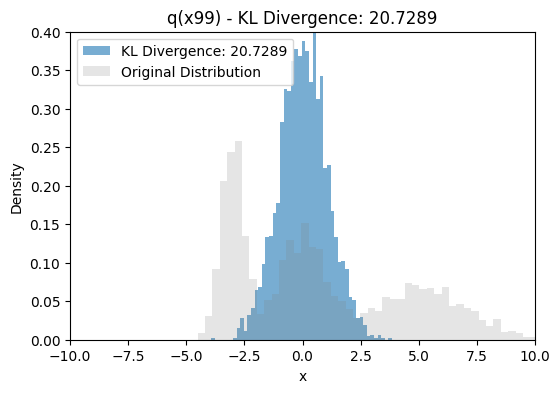

In [ ]:
T = 100
beta_min = 0.0001
beta_max = 0.1
initial_ditribution = x_0
html_filename = 'forward_diffusion.html'
run_forward_diffusion_experiment(initial_ditribution,T, "linear", {"beta_min": 0.0001, "beta_max": 0.1}, html_filename)

/tmp/ipykernel_26251/2988390170.py:39: RuntimeWarning: overflow encountered in divide
  return np.sum(p_true * np.log(p_true / p_approx))
/tmp/ipykernel_26251/2988390170.py:39: RuntimeWarning: divide by zero encountered in divide
  return np.sum(p_true * np.log(p_true / p_approx))


101


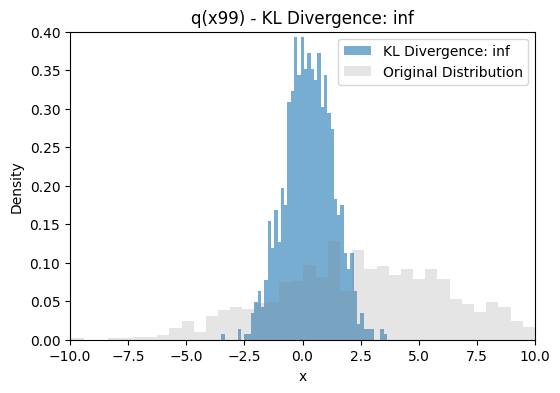

In [42]:
initial_ditribution_gaussian = np.random.normal(3, 4, num_samples)
T = 100
beta_min = 0.0001
beta_max = 0.1
html_filename = 'forward_diffusion_gaussian.html'
run_forward_diffusion_experiment(initial_ditribution_gaussian,T, "linear", {"beta_min": beta_min, "beta_max": beta_max}, html_filename)

### Reverse Diffusion
The implicit denoising model is parameterized as:
$$
p_\theta(x_{t-1}|x_t) = q(x_{t-1}|x_t, x_0) = f_\theta(x_t, t).
$$

Remember that:
$$
q(x_{t-1}|x_t, x_0) = \frac{q(x_t|x_{t-1}, x_0)q(x_{t-1}|x_0)}{q(x_t|x_0)} = \frac{q(x_t|x_{t-1})q(x_{t-1}|x_0)}{q(x_t|x_0)},
$$
where:
- $q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t I)$,
- $q(x_t | x_0) = \mathcal{N}\left(x_t; \sqrt{\bar{\alpha_t}}x_0, \left( 1 - \bar{\alpha_t} \right)I \right), \quad \bar{\alpha_t} = \prod_{i=1}^t (1-\beta_i)$,
- $q(x_{t-1} | x_0) = \mathcal{N}(x_{t-1}; \sqrt{\bar{\alpha}_{t-1}}x_0, (1 - \bar{\alpha}_{t-1})I)$.

Thus:
$$
q(x_{t-1}|x_t, x_0) \propto \exp\left(-\frac{1}{2\beta_t}\|x_t - \sqrt{1-\beta_t}x_{t-1}\|^2\right) \cdot \exp\left(-\frac{1}{2(1-\bar{\alpha}_{t-1})}\|x_{t-1} - \sqrt{\bar{\alpha}_{t-1}}x_0\|^2\right).
$$

Expanding the norms and isolating terms involving $x_{t-1}$:
$$
q(x_{t-1}|x_t, x_0) \propto \exp\left(-\frac{1}{2} \left[ A\|x_{t-1}\|^2 - 2b^\top x_{t-1} + C \right] \right),
$$
where:
$$
A = \frac{1-\beta_t}{\beta_t} + \frac{1}{1-\bar{\alpha}_{t-1}}, \quad
b = \frac{\sqrt{1-\beta_t}}{\beta_t}x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}}{1-\bar{\alpha}_{t-1}}x_0, \quad
C = \frac{1}{\beta_t}\|x_t\|^2 + \frac{\bar{\alpha}_{t-1}}{1-\bar{\alpha}_{t-1}}\|x_0\|^2.
$$

The quadratic form corresponds to a Gaussian posterior:
$$
q(x_{t-1}|x_t, x_0) = \mathcal{N}(x_{t-1}; \mu_t(x_t, x_0), \tilde{\beta}_t I),
$$
where:
$$
\mu_t(x_t, x_0) = \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar{\alpha}_t}x_0 + \frac{\sqrt{1-\beta_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t, \quad
\tilde{\beta}_t = \frac{\beta_t(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}.
$$

\paragraph{Diffusion Model Setting}
And we can get $x_0$ by having a model learn the noise $\epsilon_{\theta}(x_t, t)$ at $x_t$. Since,
$$
x_t = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1 - \bar{\alpha_t}}\epsilon_{\theta}(x_t, t),
$$
thus
$$
x_0 = \frac{1}{\sqrt{\bar{\alpha_t}}} \left(x_t - \sqrt{1 - \bar{\alpha_t}}\epsilon_{\theta}(x_t, t)\right).
$$
We only need $x_t$
$$
q(x_{t-1}|x_t, x_0 = f(x_t, \theta)) = \mathcal{N}\left(x_{t-1}; \frac{1}{\sqrt{\bar{\alpha_t}}}\left(x_t - \frac{1 - \sqrt{\tilde{\beta}_t}}{\sqrt{1 - \bar{\alpha_t}}}\epsilon_{\theta}(x_t, t)\right), \tilde{\beta}_t I\right)
$$
$$
= p_{\theta}(x_{t-1}|x_t).
$$



In [57]:
def reverse_denoising2(trajectory, betas, T, min_beta_tilde=1e-4, noise_floor=1e-4):
    alphas = 1 - betas
    alpha_bar = np.cumprod(alphas)
    xt = trajectory[-1]
    reverse_trajectory = [xt]
    x_0_trajectory = trajectory[0]
    kl_divergence=[calculate_kl_divergence(x_0_trajectory, xt)]
    for t in tqdm(reversed(range(1, T))):
        alpha_bar_t_1 = alpha_bar[t - 1]
        alpha_bar_t = alpha_bar[t]
        beta_t = betas[t - 1]
        sqrt_alpha_bar_t_1 = np.sqrt(alpha_bar_t_1)
        sqrt_alpha_bar_t = np.sqrt(alpha_bar_t)
        one_minus_alpha_bar_t = 1 - alpha_bar_t
        one_minus_alpha_bar_t_1 = 1 - alpha_bar_t_1
        
        # Calculating mu_t
        mu_t = (sqrt_alpha_bar_t_1 / one_minus_alpha_bar_t) * beta_t * x_0_trajectory + \
               (np.sqrt(alphas[t]) * one_minus_alpha_bar_t_1 / one_minus_alpha_bar_t) * xt
        
        # Calculating beta_t_tilde
        beta_t_tilde = (1 - alpha_bar_t_1) / (1 - alpha_bar_t) * beta_t
        
        # Adding noise
        noise = np.random.randn(*xt.shape) * np.sqrt(beta_t_tilde + noise_floor)
        
        # Updating xt
        xt = mu_t + noise
        reverse_trajectory.append(xt)
        kl_divergence.append(calculate_kl_divergence(x_0_trajectory, xt))
    
    return reverse_trajectory,kl_divergence

def update_plot2(frame, reverse_trajectory, kl_divergence,betas,initial_ditribution, ax):
    ax.clear()
    
    ax.hist(reverse_trajectory[frame], bins=50, density=True, alpha=0.6, label=f"KL Divergence: {kl_divergence[frame]:.4f}")
    ax.hist(initial_ditribution, bins=50, density=True, alpha=0.2, color='gray', label="Original Distribution")
    ax.set_title(f"Reverse Step {T - frame} - KL Divergence: {kl_divergence[frame]:.4f} - Beta: {betas[T - frame - 1]:.4f}")
    ax.set_xlim(-10, 10)
    ax.set_ylim(0, 0.4)
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.legend()
    
import time
    
def run_reverse_denoising_experiment(initial_ditribution,T, beta_scheduler, beta_params,filename):
    if beta_scheduler == "linear":
        betas = linear_beta_schedule(T, **beta_params)
        filename = filename.replace(".html", f"_Timesteps_{T}_Beta_min_{beta_params['beta_min']}_Beta_max_{beta_params['beta_max']}_Linear.html")
    elif beta_scheduler == "constant":
        betas = constant_beta_schedule(T, **beta_params)
        filename = filename.replace(".html", f"_Timesteps_{T}_Beta_{beta_params['beta_value']}_Constant.html")
    elif beta_scheduler == "exponential":
        betas = exponential_beta_schedule(T, **beta_params)
        filename = filename.replace(".html", f"_Timesteps_{T}_Beta_min_{beta_params['beta_min']}_Beta_max_{beta_params['beta_max']}_Exponential.html")
    else:
        raise ValueError("Invalid beta scheduler")
    # dirname=os.path.dirname(filename)
    # if not os.path.exists(dirname):
    #     os.makedirs(dirname)

    # if os.path.exists(filename):
    #     return HTML(filename)
    
    trajectory,_ = forward_diffusion(initial_ditribution, betas, T)
    frames_to_plot = range(0, T, max(np.round(T // 100), 1))
    
    reverse_trajectory,kl_divergence = reverse_denoising2(trajectory, betas, T)
    # Animate the forward diffusion
    fig, ax = plt.subplots(figsize=(6, 4))
    ani = animation.FuncAnimation(fig, update_plot2, frames=frames_to_plot, repeat=False, fargs=(reverse_trajectory,kl_divergence,betas, initial_ditribution, ax))
    ani.save(filename, writer='html', fps=30)
    #wait for the file to be created
    time.sleep(5)
    # Load and display the saved animation
    return HTML(filename)


98it [00:20,  4.76it/s]/tmp/ipykernel_26251/611732990.py:40: RuntimeWarning: divide by zero encountered in divide
  return np.sum(p_true * np.log(p_true / p_approx))
/tmp/ipykernel_26251/611732990.py:40: RuntimeWarning: overflow encountered in divide
  return np.sum(p_true * np.log(p_true / p_approx))
99it [00:20,  4.88it/s]


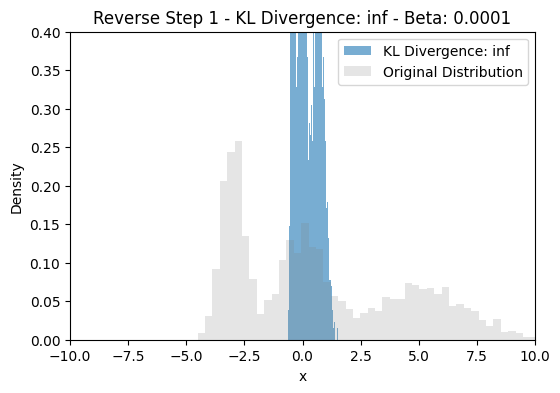

In [60]:
T=100
beta_min=0.0001
beta_max=0.1
initial_ditribution=x_0
html_filename='reverse_denoising.html'
run_reverse_denoising_experiment(initial_ditribution,T, "linear", {"beta_min": beta_min, "beta_max": beta_max}, html_filename)


/tmp/ipykernel_26251/611732990.py:40: RuntimeWarning: overflow encountered in divide
  return np.sum(p_true * np.log(p_true / p_approx))
/tmp/ipykernel_26251/611732990.py:40: RuntimeWarning: divide by zero encountered in divide
  return np.sum(p_true * np.log(p_true / p_approx))
249it [00:50,  4.93it/s]


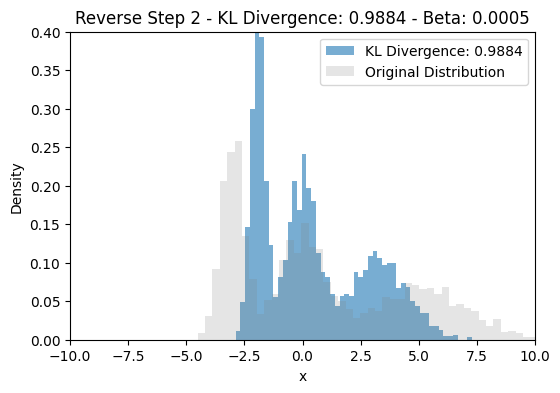

In [66]:
T=250
initial_ditribution=x_0
html_filename='reverse_denoising.html'
run_reverse_denoising_experiment(initial_ditribution,T, "linear", {"beta_min": beta_min, "beta_max": beta_max}, html_filename)

/tmp/ipykernel_26251/611732990.py:40: RuntimeWarning: overflow encountered in divide
  return np.sum(p_true * np.log(p_true / p_approx))
/tmp/ipykernel_26251/611732990.py:40: RuntimeWarning: divide by zero encountered in divide
  return np.sum(p_true * np.log(p_true / p_approx))
999it [03:19,  5.01it/s]


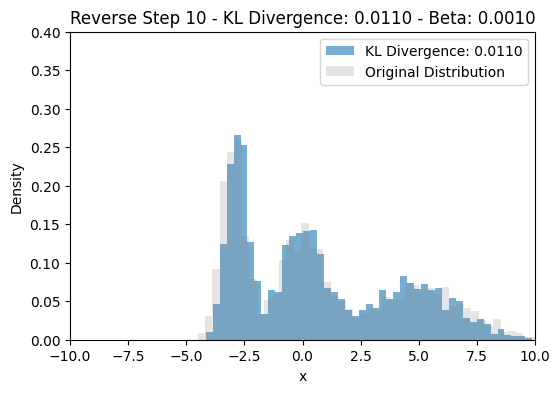

In [ ]:
T=500
initial_ditribution=x_0
html_filename='reverse_denoising.html'
run_reverse_denoising_experiment(initial_ditribution,T, "linear", {"beta_min": beta_min, "beta_max": beta_max}, html_filename)

/tmp/ipykernel_26251/611732990.py:40: RuntimeWarning: divide by zero encountered in divide
  return np.sum(p_true * np.log(p_true / p_approx))
/tmp/ipykernel_26251/611732990.py:40: RuntimeWarning: overflow encountered in divide
  return np.sum(p_true * np.log(p_true / p_approx))
99it [00:07, 14.11it/s]


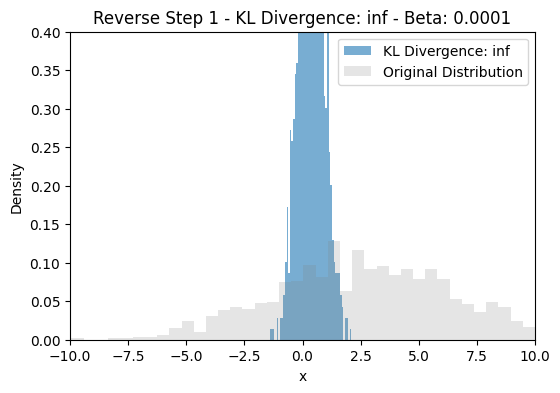

In [62]:
T=100
beta_min=0.0001
beta_max=0.1
initial_ditribution=initial_ditribution_gaussian
html_filename='reverse_denoising_gaussian.html'
run_reverse_denoising_experiment(initial_ditribution,T, "linear", {"beta_min": beta_min, "beta_max": beta_max}, html_filename)

/tmp/ipykernel_26251/611732990.py:40: RuntimeWarning: overflow encountered in divide
  return np.sum(p_true * np.log(p_true / p_approx))
/tmp/ipykernel_26251/611732990.py:40: RuntimeWarning: divide by zero encountered in divide
  return np.sum(p_true * np.log(p_true / p_approx))
249it [00:18, 13.41it/s]


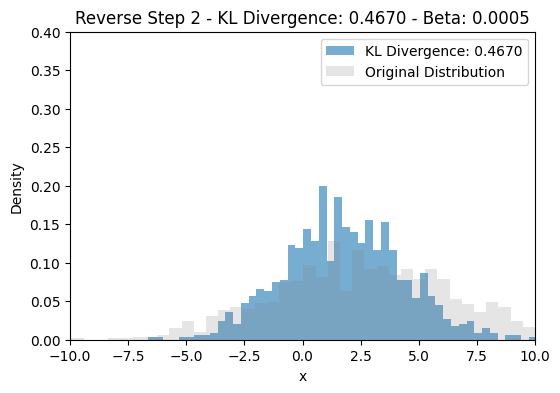

In [67]:
T=250
initial_ditribution=initial_ditribution_gaussian
html_filename='reverse_denoising_gaussian.html'
run_reverse_denoising_experiment(initial_ditribution,T, "linear", {"beta_min": beta_min, "beta_max": beta_max}, html_filename)

/tmp/ipykernel_26251/611732990.py:40: RuntimeWarning: overflow encountered in divide
  return np.sum(p_true * np.log(p_true / p_approx))
/tmp/ipykernel_26251/611732990.py:40: RuntimeWarning: divide by zero encountered in divide
  return np.sum(p_true * np.log(p_true / p_approx))
499it [00:35, 13.90it/s]


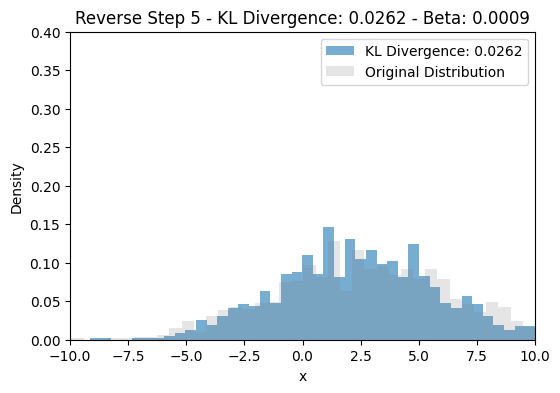

In [68]:
T=500
initial_ditribution=initial_ditribution_gaussian
html_filename='reverse_denoising_gaussian.html'
run_reverse_denoising_experiment(initial_ditribution,T, "linear", {"beta_min": beta_min, "beta_max": beta_max}, html_filename)

We notice through the denoising process that at the end the distribution seems to collapse. This is due to the coefficients of $x_t$ and $x_0$ being so low

$$
\mu_t(x_t, x_0) = \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar{\alpha}_t}x_0 + \frac{\sqrt{1-\beta_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t, \quad
$$

These coefficients are less low when the difference between each consecutive $B_t$ gets lower meaing $T$ Goes up. THis verifies the two conditions cited in the paper
- $B_t$ must be infintesimal
- Distribution $q(x_0)$ should be Gaussian. (Unfortunately we found no major difference in the results between our two intial distibutions)

## Running the Paper's Denoising Diffusion GANs
We have cloned the original Nvidia repo and adpted their scripts to work one single GPU by replacing all of their code that used ``DitributedParallel`` package to train on multiple GPUs. On the other hand this truly showed us how computationally greedy this algorithm was. We trained for 48 hours on a subset (20%) of their experiment dataset StackMNIST and this was only enough to train 10 epochs (In their paper they go up to a 1000 epochs).

Naturally we were unable to fully replicate their results but we have a rough idea of their Algorithm and thought process.




## One Iteration of Training for Denoising Diffusion GAN

### Discriminator Update
1. **Load Real data:**
   ![Real data example From Stack Mnist](DDGAN_assets/Discriminator/epoch_10_iteration_300_step_0_image_real_data_time_unknown.png)

   **Real data example from StackMNIST (stacking 3 Mnist images on top of each other)**

1. **Sample $ t $:**
   $
   t \sim \text{Uniform}(0, \text{num\_timesteps})
   $

2. **Generate noisy pairs:**
   $
   x_t \gets q(x_t | x_0)
   $

   ---

   ![Real data example From Stack Mnist](DDGAN_assets/Discriminator/epoch_10_iteration_300_step_1_image_x_t_time_3.png)

   ---

   $
   x_{t+1} \gets q(x_{t+1} | x_t)
   $


   ---
   ![Real data example From Stack Mnist](DDGAN_assets/Discriminator/epoch_10_iteration_300_step_2_image_x_tp1_time_3.png)

3. **Discriminator real loss:**
   $
   D_{\text{real}} \gets \text{Discriminator}(x_t, t, x_{t+1})
   $
   
   $
   \text{errD}_{\text{real}} \gets \text{mean}(\text{softplus}(-D_{\text{real}}))
   $
   In this case, D_real Loss: 0.7410815358161926

4. **Sample fake data:**
   $
   z \sim \mathcal{N}(0, I) 
   $
   This is Gaussian noise needed for the GAN

   $
   x_0' \gets \text{GAN}(x_{t+1}, t, z)
   $

   ---
   ![Real data example From Stack Mnist](DDGAN_assets/Discriminator/epoch_10_iteration_300_step_3_image_x_0_predict_time_3.png)

   There is a typo in this graph this case is generated from timestep t+1 (ie. In this example, 4)

   ---

   $
   x_{t}' \gets q(x_t | x_{t+1}, x_0')
   $
   forward sampling a new $x_t'$ from the generated $x_0'$

   ---

   ![Real data example From Stack Mnist](DDGAN_assets/Discriminator/epoch_10_iteration_300_step_4_image_x_pos_sample_time_3.png)

5. **Discriminator fake loss:**
   $
   D_{\text{fake}} \gets \text{Discriminator}(x_t', t, x_{t+1})
   $

   $
   \text{errD}_{\text{fake}} \gets \text{mean}(\text{softplus}(D_{\text{fake}}))
   $
   D_fake Loss: 0.7039969563484192
6. **Update Discriminator:**
   $
   \text{Backpropagate } errD_{\text{real}} + errD_{\text{fake}} \text{ and update.}
   $
   

## Generator Update

1. **Discriminator in evaluation mode.**

2. **Sample $ t $ again:**
   $
   t \sim \text{Uniform}(0, \text{num\_timesteps})
   $
   t=1 in the following example
3. **Generate noisy pairs:**
   $
   x_t \gets q(x_t | x_0)
   $

   ---

   ![Real data example From Stack Mnist](DDGAN_assets/Generator/epoch_10_iteration_300_step_5_image_x_t_time_1.png)

   ---
   
   $
   x_{t+1} \gets q(x_{t+1} | x_t)
   $

   ---
   ![Real data example From Stack Mnist](DDGAN_assets/Generator/epoch_10_iteration_300_step_6_image_x_tp1_time_1.png)

4. **Sample fake data:**
   $
   z \sim \mathcal{N}(0, I)
   $

   $
   x_0' \gets \text{GAN}(x_{t+1}, t, z)
   $

   ---
   ![epoch_10_iteration_300_step_7_image_x_0_predict_time_1.png](DDGAN_assets/Generator/epoch_10_iteration_300_step_7_image_x_0_predict_time_1.png)
   
   ---
   $
   x_{t}' \gets q(x_t | x_{t+1}, x_0')
   $
    
   ---
   ![epoch_10_iteration_300_step_7_image_x_0_predict_time_1.png](DDGAN_assets/Generator/epoch_10_iteration_300_step_8_image_x_pos_sample_time_1.png)

5. **Generator loss:**
   $
   D_{\text{fake}} \gets \text{Discriminator}(x_t', t, x_{t+1})
   $
   
   $
   \text{errG} \gets \text{mean}(\text{softplus}(-D_{\text{fake}}))
   $
   Gen Loss: 1.2820032835006714

6. **Backpropagate $ \text{errG} $ and update.**  


## Sampling with Denoising Diffusion GAN

### Input:
- `GAN`, `num_timesteps=4`, `x_noisy`

### Steps:

0. Generate $ x_{noisy} $ this will be the quivalent to $x_4$
1. $x_{current} \gets x_{noisy}$
2. For $ t $ in range $ (num\_timesteps - 1, 0) $:
   0. 
   1. Sample $ z \sim \mathcal{N}(0, I) $
   2. Generate $ x_0' \gets GAN(x_{current}, t, z) $
   3. Set $ x_{t}' \gets q(x_{t}|x_{t+1}, x_0') $
   4. set $x_{current} \gets x_{t}'$

**Example**
Sampled $x_4$ Gaussian noise

---
![x_4](DDGAN_assets/Sampling/epoch_9_iteration_0_step_5_image_x_t_sample_time_4.png)

---
Generated $x_{0, t=4}$ from timestep $x_4$

![x_{0, t=4}'](DDGAN_assets/Sampling/epoch_9_iteration_0_step_3_image_x_0_predict_time_3.png)


---
Froward noised $x_3$ from image $x_{0, t=4}$


![x_3](DDGAN_assets/Sampling/epoch_9_iteration_0_step_4_image_x_pos_sample_time_3.png)


---
Generated $x_{0, t=3}$ from timestep $x_3$
![x_{0, t=3}](DDGAN_assets/Sampling/epoch_9_iteration_0_step_3_image_x_0_predict_time_2.png)


---
Froward noised $x_2$ from image $x_{0, t=3}$

![x_2.png](DDGAN_assets/Sampling/epoch_9_iteration_0_step_4_image_x_pos_sample_time_2.png)

---
Generated $x_{0, t=2}$ from timestep $x_2$

![x_{0, t=2}.png](DDGAN_assets/Sampling/epoch_9_iteration_0_step_3_image_x_0_predict_time_1.png)

---
Froward noised $x_1$ from image $x_{0, t=2}$

![x_1.png](DDGAN_assets/Sampling/epoch_9_iteration_0_step_4_image_x_pos_sample_time_1.png)

---
Generated $x_{0, t=1}$ from timestep $x_1$

![x_{0, t=1}.png](DDGAN_assets/Sampling/epoch_9_iteration_0_step_3_image_x_0_predict_time_0.png)

---
Froward noised $x_0$ from image $x_{0, t=1}$

![x_0_f.png](DDGAN_assets/Sampling/epoch_9_iteration_0_step_4_image_x_pos_sample_time_0.png)

---

Unfortunately, we do not have the compute to run this for the intended number of epochs but we manage to delve into their code in order to modify it by making it available one GPU and to plot their steps and results.